In [1]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("myApp").getOrCreate()

# Enable Adaptive Query Execution
spark.conf.set("spark.sql.adaptive.enabled", "true")

# num_executors = spark.sparkContext._jsc.sc().getExecutorMemoryStatus().keySet().size()

# # Print the number of executors
# print("Number of Executors:", num_executors)



VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1707618378361_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Get executor memory
executor_memory = spark.sparkContext.getConf().get("spark.executor.memory")
print("Executor Memory:", executor_memory)

# Get executor cores
executor_cores = spark.sparkContext.getConf().get("spark.executor.cores")
print("Executor Cores:", executor_cores)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Executor Memory: 9486M
Executor Cores: 4

# **E-commerce Key Metrics Analysis**

The goal of this notebook is to take a look at the store's key performance indicators and also find insights from the data that can help the store improve its revenue and performance goals.

Here are a few of the questions I am going to answer:
* **Top 10 Highest Grossing Products**
* **Top 10 Products by Earnings per Session**
* **Top 10 Products by Conversion Rates**
* **Most Cross-sold Product Bundles**
* **Average Order Value**
* **Customer Lifetime Value**

Now, without further ado, let's dive deep into the notebook.
***

In [2]:
# Read CSV file from S3 into a DataFrame
df = spark.read.csv('s3://emr-spark-bucket-1/raw/2019-Oct.csv', header=True, inferSchema=True)

# Show the DataFrame schema and first few rows
df.printSchema()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

In [8]:
# Get the number of rows in the DataFrame
num_rows = df.count()

# Print the number of rows
print("Number of Rows:", num_rows)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Rows: 42448764

<h3> Prepping the Data </h3>

Currently, the table we are working with (raw_events_data) stores all of the information from products, website sessions, and website events. (Just like in the picture below)

Unfortunately, the way this table is structured leads to a lot of redundant data being stored, thus making our analysis a lot slower and making it harder for us to make sense of the data.

So before we begin actually looking for insights, let's transform this big clunky table into 3 smaller ones by applying a few normalizing principles.

After we normalize the table, we will end up with 3 different tables, they are:
1. products: Holds unique information from the products
1. user_sessions table: Holds unique information from the website sessions
1. events: Holds unique information from the website events  

In [13]:
from pyspark.sql.functions import avg, coalesce, collect_list, array_contains

product_df = df.select('product_id', 'category_code', 'brand', 'price')

# product_df = product_df.groupBy('product_id', "category_code").agg(collect_list("brand")[0].alias("cleaned_brand"))

product_df1 = product_df.groupBy('product_id', 'category_code').agg(avg('price').alias('price'))
product_df2 = product_df.groupBy('product_id', 'category_code', 'brand').agg(avg('price').alias('price'))

print("Number of Rows:", product_df1.count())
print("Number of Rows:", product_df2.count())
# print("Number of Rows:", test.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Rows: 166794
Number of Rows: 174537

we see that number of rows when grouped be 'product_id', 'category_code', 'brand' > when grouped by 'product_id', 'category_code'. This means there are products with same id and category_code, but somehow the brand is different.
This could be caused bye null values or mistakes in brand names.

In [35]:
df.select('product_id', 'category_code', 'brand', 'price').filter(col('price') != 0).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

42380091

In [32]:
# from pyspark.sql.functions import size, col, udf
# from pyspark.sql.types import StringType
# from collections import Counter


# def most_repeated_brand(arr):
    
#     if len(arr) > 0:
#         # Count occurrences of each element in the list
#         counter = Counter(arr)

#         # Find the most common value
#         first_tuple = counter.most_common(1)[0]

#         # Extract the most common value and its count
#         most_repeated_brand = first_tuple[0]

#         return most_repeated_brand
#     elif len(arr) == 0:
#         return None
        

# Register the UDF
# udf_most_repeated_brand = udf(most_repeated_brand, StringType())

# product_df = df.select('product_id', 'category_code', 'brand', 'price')
# product_df = product_df.filter(col('price') != 0)

# test = product_df.groupBy('product_id', 'category_code','brand').agg(collect_list("brand").alias("brand_array"))

# test = test.withColumn('most_repeated_brand', udf_most_repeated_brand('brand_array'))

# test.show()
            

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+----------+--------------------+-------------------+
|product_id|       category_code|     brand|         brand_array|most_repeated_brand|
+----------+--------------------+----------+--------------------+-------------------+
|   1002870|electronics.smart...|    gionee|    [gionee, gionee]|             gionee|
|   1002876|electronics.smart...|      NULL|                  []|               NULL|
|   1003015|electronics.smart...|        lg|[lg, lg, lg, lg, ...|                 lg|
|   1003028|electronics.smart...|     apple|[apple, apple, ap...|              apple|
|   1003141|electronics.smart...|     apple|[apple, apple, ap...|              apple|
|   1003385|electronics.smart...|    gionee|[gionee, gionee, ...|             gionee|
|   1003440|electronics.smart...|    xiaomi|[xiaomi, xiaomi, ...|             xiaomi|
|   1003461|electronics.smart...|    xiaomi|[xiaomi, xiaomi, ...|             xiaomi|
|   1003761|electronics.smart...|      sony|[sony, son

In [45]:
from pyspark.sql.functions import col, array_distinct, size, round

df = df.filter(col('price') != 0)

product_df = df.select('product_id', 'category_code', 'brand', 'price')

product_df = product_df.groupBy('product_id', 'category_code','brand').agg(collect_list("brand").alias("brand_array"),
                                                                    round(avg('price'), 3).alias('price'))
product_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+----------+--------------------+--------+
|product_id|       category_code|     brand|         brand_array|   price|
+----------+--------------------+----------+--------------------+--------+
|   1002870|electronics.smart...|    gionee|    [gionee, gionee]|   64.09|
|   1002876|electronics.smart...|      NULL|                  []|   198.2|
|   1003015|electronics.smart...|        lg|[lg, lg, lg, lg, ...| 132.827|
|   1003028|electronics.smart...|     apple|[apple, apple, ap...|  615.54|
|   1003141|electronics.smart...|     apple|[apple, apple, ap...| 378.898|
|   1003385|electronics.smart...|    gionee|[gionee, gionee, ...|  123.56|
|   1003440|electronics.smart...|    xiaomi|[xiaomi, xiaomi, ...|  125.87|
|   1003461|electronics.smart...|    xiaomi|[xiaomi, xiaomi, ...| 381.341|
|   1003761|electronics.smart...|      sony|[sony, sony, sony...| 953.779|
|   1003774|electronics.smart...|     nokia|[nokia, nokia, no...|   370.2|
|   1003902|electronics.s

In [47]:
product_df.filter(size(array_distinct("brand_array")) > 1).show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------+-----+-----------+-----+
|product_id|category_code|brand|brand_array|price|
+----------+-------------+-----+-----------+-----+
+----------+-------------+-----+-----------+-----+

given there is no record -> the mismatch is sovled 

In [54]:
# product_df = df.select('product_id', 'category_code', 'brand', 'price')

# product_df = product_df.groupBy('product_id', "category_code").agg(collect_list("brand")[0].alias("brand"))

# product_df.filter((product_df["brand"].isNull()) & (product_df["price"] != 0)).show()

# product_df.filter(product_df["product_id"]==17200506).groupBy("category_code").agg(collect_list("brand")[0].alias("brand")).show()


# print("Number of Rows:", product_df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|       category_code|brand|
+--------------------+-----+
|furniture.living_...| NULL|
+--------------------+-----+

In [46]:
product_df.select('product_id').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

165647

In [23]:
df.select('product_id').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

166794

In [24]:
# Get the number of partitions
num_partitions = df.rdd.getNumPartitions()
print("Number of partitions:", num_partitions)

# Calculate the size of each partition
partition_sizes = df.rdd.mapPartitions(lambda it: [sum(1 for _ in it)])
print("Size of each partition:", partition_sizes.collect())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of partitions: 43
Size of each partition: [1004867, 1004988, 1002792, 1002843, 999910, 1001146, 1002615, 1007353, 1008107, 1013699, 1012731, 1010320, 1007983, 1009704, 1009447, 1010788, 1009214, 1001178, 1001210, 999010, 1002219, 1002947, 1001996, 1005158, 1005846, 1002482, 1003924, 1006213, 1004098, 1003501, 1005383, 1004993, 1002506, 1003703, 1004324, 1002924, 999663, 1006479, 1007015, 1006940, 1005203, 1004999, 236343]

In [48]:
product_df = product_df.select('product_id', 'category_code', 'brand', 'price')
product_df = product_df.coalesce(1)

product_df.write.format('parquet') \
    .option("compression", "snappy")\
    .option("path", "s3://emr-spark-bucket-1/cleaned/products")\
    .bucketBy(3, 'product_id').sortBy("product_id") \
    .mode("overwrite") \
    .saveAsTable('products')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
user_df = df.select('user_session','user_id').dropDuplicates(['user_session'])

user_df = user_df.coalesce(1)

user_df.write.format('parquet') \
    .option("compression", "snappy")\
    .option("path", "s3://emr-spark-bucket-1/cleaned/sessions")\
    .bucketBy(3, 'user_session').sortBy("user_session") \
    .mode("overwrite") \
    .saveAsTable('sessions')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# user_df = df.select('user_session','user_id').dropDuplicates(['user_id'])
# print("Number of Rows:", user_df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Rows: 3022290

In [51]:
events = df.select('event_time','event_type','product_id','user_session')


events = events.coalesce(5)

events.write.format('parquet') \
    .option("compression", "snappy")\
    .option("path", "s3://emr-spark-bucket-1/cleaned/events")\
    .bucketBy(3, 'product_id', 'user_session').sortBy("product_id", 'user_session') \
    .mode("overwrite") \
    .saveAsTable('events')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As you can see, we have just saved a lot of space, which will be very handy for this e-commerce store if it wants to scale the database and start storing other data points (such as traffic sources, cost of goods sold, etc).

And now that we have prepped the data, let's finally start squeezing the numbers to find some insights.

***


<h2> Product Intelligence </h2>


<h3> Highest Grossing Product </h3>

To start off our analysis, let's find out what are the top 10 highest-grossing products from our store, that is, the products that makes the most amount of money in terms of revenue...

In [52]:
from pyspark.sql.functions import col, sum, when, lit, round, collect_list, count, size
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# Read the Parquet files with options
products = spark.read \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .parquet("s3://emr-spark-bucket-1/cleaned/products/")

# Read the Parquet files with options
events = spark.read \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .parquet("s3://emr-spark-bucket-1/cleaned/events/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
# 1. Left join events and products DataFrames
events_on_products = events.join(products, events.product_id == products.product_id, "left").drop(products.product_id)

events_on_products.cache()

events_on_products.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+----------+------------------------------------+----------------------+-------+-------+
|event_time         |event_type|product_id|user_session                        |category_code         |brand  |price  |
+-------------------+----------+----------+------------------------------------+----------------------+-------+-------+
|2019-10-26 08:40:21|view      |1000978   |008bd148-aca6-4b64-aa75-f363813b796a|electronics.smartphone|samsung|321.841|
|2019-10-23 05:58:36|view      |1000978   |013d4837-1e7f-4533-b46f-ff2bc57e2040|electronics.smartphone|samsung|321.841|
|2019-10-22 20:23:42|view      |1000978   |043b0b92-a2fc-431f-bec4-abe4207e15cf|electronics.smartphone|samsung|321.841|
|2019-10-22 20:27:02|view      |1000978   |043b0b92-a2fc-431f-bec4-abe4207e15cf|electronics.smartphone|samsung|321.841|
|2019-10-22 20:27:13|view      |1000978   |043b0b92-a2fc-431f-bec4-abe4207e15cf|electronics.smartphone|samsung|321.841|
|2019-10-30 21:24:48|view      |1000978 

In [55]:
# 2. Filter for rows where the event type is 'purchase'
purchase_events = events_on_products.filter(col("event_type") == "purchase")

# 3. Group by 'product_id' and sum the 'price'
revenue_per_product = purchase_events.groupby("product_id").agg(sum("price").alias("total_revenue"))

# 4. Sort the results by total revenue in descending order
top_10_products = revenue_per_product.orderBy(col("total_revenue").desc()).limit(10)

# 5. Collect the top 10 products as a Pandas DataFrame
top_10_products_df = top_10_products.toPandas()




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

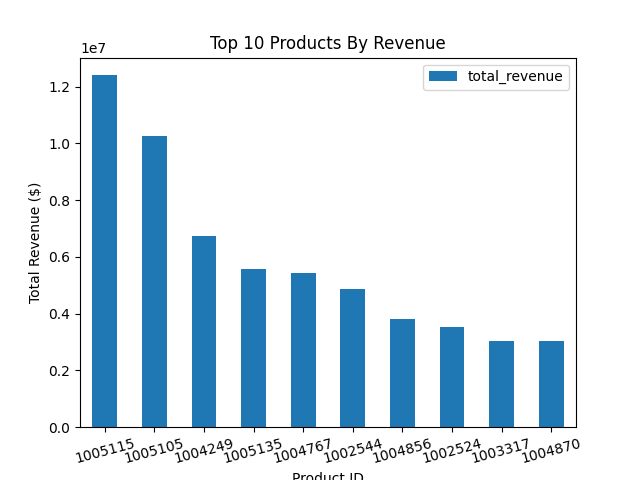

In [61]:
# 6. Plot the results using Matplotlib
top_10_products_df.plot(kind='bar', x='product_id', y='total_revenue', title='Top 10 Products By Revenue',
                        xlabel='Product ID', ylabel='Total Revenue ($)')

plt.xticks(rotation=15)
plt.show()
%matplot plt

<h3 > Highest Earnings Per Session </h3>

Now, total revenue is not a meaningful metric on its own, especially if we ignore the number of sessions that landed on the product page.

After all, if you are sending a lot of traffic to a page that is doing a poor job at converting users, you could easily be leaving money on the table.

So, to account for the fact that different products have different conversion rates, let's find out what are the top products by earnings per session.

In [57]:
# Define the condition
view_condition = (col('event_type') == 'view')
purchase_condition =  (col('event_type') == 'purchase')

# Group by 'group' column and filter rows based on the condition, then perform aggregation
revenue_and_views  = events_on_products.groupBy('product_id') \
    .agg(sum(when(purchase_condition, col('price')).otherwise(lit(0))).alias('total_revenue'),
        sum(when(view_condition, lit(1)).otherwise(lit(0))).alias('total_views'),
        sum(when(purchase_condition, lit(1)).otherwise(lit(0))).alias('total_purchases'))\
    .withColumn("revenue_per_view", round(col('total_revenue') / col('total_views'), 3))\
    .orderBy(col("revenue_per_view").desc())

revenue_and_views_pd = revenue_and_views.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
revenue_and_views.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+-----------+---------------+----------------+
|product_id|     total_revenue|total_views|total_purchases|revenue_per_view|
+----------+------------------+-----------+---------------+----------------+
|  12720438|            670.28|          2|              2|          335.14|
|  20500270|            308.63|          1|              1|          308.63|
|  26205483|            271.03|          1|              1|          271.03|
|  21405915|            270.79|          1|              1|          270.79|
|  14701426|             245.8|          1|              1|           245.8|
|  12716845|            244.02|          1|              1|          244.02|
|   4201530|23128.049999999996|        107|             15|          216.15|
|   1801789|          3586.656|         17|              2|          210.98|
|   8500472|          6098.448|         29|              3|         210.291|
|  28102364|           1482.68|          8|              4|         185.335|

<h3> Conversion Rates Per Product </h3>

We can also find out what are the products with the highest conversion rates, since these products could also be worth pushing traffic to and their landing page designs be used as controls in A/B split tests.

So let's discover what are the top 10 products with the highest conversion rates given that the products is viewed at least 5 times.

In [62]:
conversation_rate = revenue_and_views.filter(col('total_views') >= 5) \
    .withColumn("conversion_rate", col('total_purchases') / col('total_views')) \
    .orderBy(col("conversion_rate").desc()) \

                                            
conversation_rate.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+-----------+---------------+----------------+-------------------+
|product_id|     total_revenue|total_views|total_purchases|revenue_per_view|    conversion_rate|
+----------+------------------+-----------+---------------+----------------+-------------------+
|  26009581|             29.46|          5|              3|           5.892|                0.6|
|  50300425|              30.9|         11|              6|           2.809| 0.5454545454545454|
|  28102364|           1482.68|          8|              4|         185.335|                0.5|
|  12718754|             863.6|         11|              5|          78.509|0.45454545454545453|
|  10800091|              27.8|          5|              2|            5.56|                0.4|
|  28101594|264.09000000000003|          8|              3|          33.011|              0.375|
|  13103009|4507.6900000000005|         30|             11|         150.256|0.36666666666666664|
|  26010152|2.9699999999999998

In [64]:
sessions = spark.read \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .parquet("s3://emr-spark-bucket-1/cleaned/sessions/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
events_on_users = events.join(sessions, events.user_session == sessions.user_session, "left").drop(sessions.user_session)

events_on_users.cache()

events_on_users.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+----------+--------------------+---------+
|         event_time|event_type|product_id|        user_session|  user_id|
+-------------------+----------+----------+--------------------+---------+
|2019-10-27 14:59:30|      view|   1004209|00019495-9f33-48f...|564555327|
|2019-10-23 21:47:22|      view|  12700733|0002854a-13ef-490...|543073137|
|2019-10-23 21:46:23|      view|  12711147|0002854a-13ef-490...|543073137|
|2019-10-23 21:45:52|      view|  12711761|0002854a-13ef-490...|543073137|
|2019-10-23 21:47:09|      view|  12714302|0002854a-13ef-490...|543073137|
|2019-10-23 21:46:30|      view|  12720202|0002854a-13ef-490...|543073137|
|2019-10-23 21:46:12|      view|  12720618|0002854a-13ef-490...|543073137|
|2019-10-23 21:45:08|      view|  12700737|0002854a-13ef-490...|543073137|
|2019-10-23 21:46:44|      view|  12700738|0002854a-13ef-490...|543073137|
|2019-10-23 21:45:34|      view|  12709558|0002854a-13ef-490...|543073137|
|2019-10-23 21:46:36|    

In [81]:
session_purchases = events_on_users.filter(col('event_type') == 'purchase')\
               .groupBy("user_session").agg(collect_list("product_id").alias("purchase_bundles"),
                                           count('user_session').alias('purchases_per_session'))\
               .filter(col('purchases_per_session') > 1)\
               .withColumn("num_of_distinct_products", size(array_distinct("purchase_bundles")))


session_purchases.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------------+------------------------+
|        user_session|    purchase_bundles|purchases_per_session|num_of_distinct_products|
+--------------------+--------------------+---------------------+------------------------+
|013d60d1-6e1c-46d...| [1004856, 16400207]|                    2|                       2|
|01f873cd-080f-497...|  [1004566, 1004566]|                    2|                       1|
|0282fc25-6010-44b...|[1004767, 1004873...|                    3|                       3|
|039a5c48-9435-4a1...|  [1004930, 5100566]|                    2|                       2|
|03fd0b1c-adb6-450...|[1004794, 1004999...|                    4|                       4|
|049d6949-4f80-4fa...|[1004838, 1004838...|                    3|                       1|
|05be52d9-2856-4b9...|[26200150, 26402516]|                    2|                       2|
|0624e13e-1918-469...|  [1004246, 1004249]|                    2|                       2|

And those were the product groups with the most amount of cross-sells.
As you can probably tell already, most of these groups are comprised of only one product.

Since we filtered only the sessions where more than 1 item was bought, this indicates that customers bought only one product in a given session but ended up purchasing multiple items of these same products.

And so their most common upsell path seems to be offering more of the same, instead of offering different products.

In case you are curious, we can also find out what are the actual product bundles (that is, those with 2 different products purchased) with the most amount of sales.

<h3> Most Sold Product Pairs </h3>

In [75]:
from itertools import combinations
from pyspark.sql.functions import udf, explode, array_sort
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
def get_products_pairs(arr):
    if len(arr) > 2:
        return list(combinations(arr, 2))
    else:
        return [arr, [0, 0]]

# Register the UDF
udf_get_products_pairs = udf(get_products_pairs, ArrayType(ArrayType(IntegerType())))

# Apply the UDF to generate combinations
session_purchases = session_purchases.withColumn("product_pairs", udf_get_products_pairs("purchase_bundles"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
session_purchases.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------------+------------------------+--------------------+
|        user_session|    purchase_bundles|purchases_per_session|num_of_distinct_products|       product_pairs|
+--------------------+--------------------+---------------------+------------------------+--------------------+
|013d60d1-6e1c-46d...| [1004856, 16400207]|                    2|                       2|[[1004856, 164002...|
|01f873cd-080f-497...|  [1004566, 1004566]|                    2|                       1|[[1004566, 100456...|
|0282fc25-6010-44b...|[1004767, 1004873...|                    3|                       3|[[1004767, 100487...|
|039a5c48-9435-4a1...|  [1004930, 5100566]|                    2|                       2|[[1004930, 510056...|
|03fd0b1c-adb6-450...|[1004794, 1004999...|                    4|                       4|[[1004794, 100499...|
|049d6949-4f80-4fa...|[1004838, 1004838...|                    3|                       1|[[1004838, 100

In [84]:
# session_purchases = session_purchases.filter(col('num_of_distinct_products') > 1)
product_pairs = session_purchases.select(explode("product_pairs").alias("product_pairs"))\
                               .withColumn("product_pairs", array_sort(col("product_pairs")))\
                               .groupBy("product_pairs").agg(count("product_pairs").alias("num_of_purchases"))\
                               .filter(col("product_pairs") != lit([0, 0]))\
                               .orderBy(col("num_of_purchases").desc()) 

product_pairs.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+----------------+
|     product_pairs|num_of_purchases|
+------------------+----------------+
|[1004856, 1004856]|            3312|
|[1004767, 1004767]|            2920|
|[5100563, 5100563]|            2251|
|[1004833, 1004833]|            1959|
|[4804056, 4804056]|            1821|
|[1002544, 1002544]|            1408|
|[1004870, 1004870]|            1392|
|[1005115, 1005115]|            1196|
|[1004767, 1004856]|            1043|
|[1004249, 1004249]|             967|
|[1004836, 1004836]|             951|
|[1004833, 1004856]|             842|
|[1002524, 1002524]|             814|
|[1005105, 1005105]|             799|
|[5100816, 5100816]|             694|
|[1004873, 1004873]|             682|
|[1002633, 1002633]|             682|
|[1004741, 1004741]|             649|
|[1004767, 1004833]|             605|
|[1005100, 1005100]|             591|
+------------------+----------------+
only showing top 20 rows

In [85]:
# Define a UDF to check for duplicates in an array
def has_mixed_pairs(arr):
    return arr[0] != arr[1]

# Register the UDF
udf_mixed_pair = udf(has_mixed_pairs, BooleanType())

# Filter out rows where the array has duplicates
product_pairs .filter(udf_mixed_pair("product_pairs")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+----------------+
|     product_pairs|num_of_purchases|
+------------------+----------------+
|[1004767, 1004856]|            1043|
|[1004833, 1004856]|             842|
|[1004767, 1004833]|             605|
|[1004767, 1004870]|             530|
|[1004767, 1004836]|             410|
|[1004836, 1004856]|             336|
|[1005105, 1005115]|             320|
|[1004833, 1004836]|             290|
|[1004249, 1005115]|             285|
|[1002544, 1002633]|             268|
|[1004767, 1004873]|             263|
|[1002524, 1002544]|             253|
|[1004209, 1004856]|             241|
|[1004870, 1004873]|             227|
|[1004750, 1004767]|             224|
|[1004856, 1004870]|             220|
|[1004750, 1004856]|             213|
|[1004750, 1004833]|             210|
|[1004856, 1004858]|             198|
|[1002544, 1003306]|             191|
+------------------+----------------+
only showing top 20 rows

<h3> Average Order Value </h3>

In [ ]:
# # 1) Merge products table with sessions_on_events table
# products_bought_by_session = events_on_users.filter(col('event_type') == 'purchase') \
#     .select('user_session', 'product_id')
# session_and_price = products_bought_by_session.join(products, 'product_id', 'left') \
#     .select('user_session', 'price')

# # 2) Group by user_session and sum the price of goods purchased
# sum_products_bought_per_session = session_and_price.groupBy('user_session') \
#     .sum('price') \
#     .withColumnRenamed('sum(price)', 'total_price') \
#     .orderBy('total_price', ascending=False)

# # 3) Calculate Average Order Value (AOV)
# sum_products_bought_per_session.createOrReplaceTempView('sum_products_bought_per_session')
# aov_df = spark.sql("SELECT SUM(total_price) / COUNT(DISTINCT user_session) AS aov FROM sum_products_bought_per_session")
# aov = aov_df.collect()[0]['aov']
